In [1]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import optim
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
dataPath = "data"
os.makedirs(dataPath, exist_ok=True)

In [5]:
trainDatasets = datasets.MNIST(dataPath, 
                              train = True, 
                              download = True,
                              transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize([0.5], [0.5])]))

In [6]:
trainDatasets[1000][1]

0

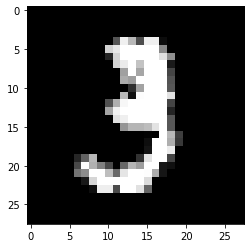

In [7]:
imageData , labelData = trainDatasets[10]
plt.imshow(to_pil_image(imageData), cmap = "gray")
plt.show()

In [8]:
# def visualization():
#     for i in range(np.random.randint(1, 30000, 10)):
#         imageData , labelData = trainDatasets[1000]
#         plt.imshow(to_pil_image(imageData), cmap = "gray")
#         plt.show()

In [9]:
trainDataLoader = DataLoader(trainDatasets,
                             batch_size = 64,
                            shuffle =True)

In [10]:
for x, y in trainDataLoader:
    print("X Data shape is : {}  and Y datasets shape is  {}".format(x.shape, y.shape))
    break

X Data shape is : torch.Size([64, 1, 28, 28])  and Y datasets shape is  torch.Size([64])


In [11]:
len(trainDatasets[0])

2

In [12]:
nn.Linear(1024, int(np.prod([28, 28,1])))

Linear(in_features=1024, out_features=784, bias=True)

In [13]:
class Generator(nn.Module):
    def __init__(self, parameter):
        #Parent Class
        super().__init__()
        self.noise = parameter['noise']
        self.image_size = parameter['image_size']
        
        
        self.model =  nn.Sequential(
            *self.fc_layers(self.noise, 128, normalize = False),
            *self.fc_layers(128, 256),
            *self.fc_layers(256, 512), 
            *self.fc_layers(512, 1024),
            nn.Linear(1024, int(np.prod(self.image_size))),
            nn.Tanh()
        )
        
    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), *self.image_size)
        return image
    
    
    def fc_layers(self, in_channel,out_channel, normalize = True):
        layers = []
        layers.append(nn.Linear(in_channel, out_channel))
        
        if normalize:
            layers.append(nn.BatchNorm1d(out_channel, 0.8))
            
        layers.append(nn.LeakyReLU(0.2))
        return layers
        

In [14]:
params = {'noise': 100, 
         "image_size": (1, 28, 28)}

In [15]:
x = torch.randn(16, 100).to(device) # noise value

In [16]:
print(x)

tensor([[ 1.0134,  0.1997,  0.3881,  ..., -0.2176,  0.2661,  1.2559],
        [ 0.4855,  0.5847, -0.6355,  ..., -1.2458,  0.7239,  0.1093],
        [-0.6293, -0.5957,  2.3788,  ..., -1.6559,  2.5240,  2.4114],
        ...,
        [-1.2300,  0.2386, -1.3510,  ...,  0.0835, -0.2757, -1.1334],
        [-1.4731, -0.7084,  0.8645,  ..., -0.2139,  0.3637, -0.1341],
        [-0.4028, -0.0260, -0.9059,  ...,  0.2042,  0.2320, -0.5506]])


In [17]:
model_generator = Generator(params).to(device)
model_generator_output = model_generator(x)
print("Our Generator Model Output: {}".format(model_generator_output.shape))

Our Generator Model Output: torch.Size([16, 1, 28, 28])


In [18]:
class Discriminator(nn.Module):
    def __init__(self, parameter):
        #Parent Class
        super().__init__()
        self.image_size = parameter['image_size']
        
        self.model = nn.Sequential(nn.Linear(int(np.prod(self.image_size)), 512), 
                                  nn.LeakyReLU(0.2), 
                                   
                                  nn.Linear(512, 256), 
                                  nn.LeakyReLU(0.2),
                                   
                                  nn.Linear(256, 128),
                                  nn.LeakyReLU(0.2),
                                   
                                  nn.Linear(128, 1), 
                                  nn.Sigmoid()
                                  )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [19]:
x = torch.randn(16, 1, 28, 28).to(device)

In [20]:
model_discriminator = Discriminator(params).to(device)
model_discriminator_output = model_discriminator(x)
print("Our Generator Model Output: {}".format(model_discriminator_output.shape))

Our Generator Model Output: torch.Size([16, 1])


In [21]:
def weight_initialize(model):
    className = model.__class__.__name__
    
    if className.find("Linear")!=-1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
        
    
    if className.find("BatchNorm")!=-1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [22]:
model_generator.apply(weight_initialize)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [23]:
model_discriminator.apply(weight_initialize)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [24]:
lossFunction = nn.BCELoss()# Binary Cross Entropy Loss

In [25]:
learning_rate = 0.001
beta1 = 0.5

In [26]:
optimizer_gen = optim.Adam(model_generator.parameters(),
                       lr = learning_rate,
                       betas = (beta1, 0.999))
optimizer_dis = optim.Adam(model_discriminator.parameters(),
                       lr = learning_rate,
                       betas = (beta1, 0.999))

In [27]:
real_label = 1.0
fake_label = 0.0

In [28]:
noiseV = params["noise"]
num_epochs = 5

In [29]:
loss_history = {"gen": [],
               "dis": []}

In [30]:
batch_count = 0

In [31]:
start_time = time.time()
model_discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [32]:
model_generator.train()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [38]:
for epoch in range(num_epochs):
    for x_batch, y_batch in trainDataLoader:
        batch_size = x_batch.size(0)
        x_batch = x_batch.to(device)
        
        y_batch_real = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        y_batch_fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)
        
        
        model_generator.zero_grad()
        noise = torch.randn(batch_size, noiseV, device =device)
        out_gen = model_generator(noise)
        out_dis = model_discriminator(out_gen)
        
        loss_gen = lossFunction(out_dis, y_batch_real)
        loss_gen.backward()
        optimizer_gen.step()
        
        
        model_discriminator.zero_grad()
        out_real = model_discriminator(x_batch)
        out_fake = model_discriminator(out_gen.detach())
        
        loss_real = lossFunction(out_real, y_batch_real) 
        loss_fake = lossFunction(out_fake, y_batch_fake) 
        
        loss_dis = (loss_real + loss_fake )/2
        
        loss_dis.backward()
        optimizer_dis.step()
        
        loss_history["gen"].append(loss_gen.item())
        loss_history["dis"].append(loss_dis.item())
        
        batch_count +=1
        
        if batch_count%1000 == 0:
            print("Epochs : {}, G_loss: {}, D_loss:{}".format(epoch, loss_gen.item(),loss_dis.item()))
        

Epochs : 1, G_loss: 0.0, D_loss:50.0
Epochs : 2, G_loss: 0.0, D_loss:50.0
Epochs : 3, G_loss: 0.0, D_loss:50.0
Epochs : 4, G_loss: 0.0, D_loss:50.0


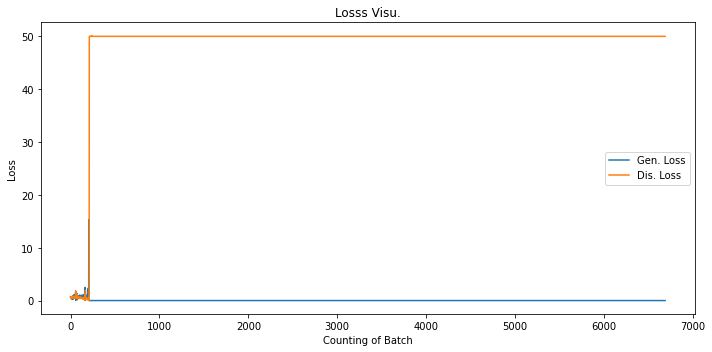

In [39]:
plt.figure(figsize = (10, 5))
plt.title("Loss Approaches")
plt.plot(loss_history["gen"], label = "Gen. Loss")
plt.plot(loss_history["dis"], label = "Dis. Loss")
plt.xlabel("Counting of Batch")
plt.ylabel("Loss")
plt.title("Losss Visu.")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
model_generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [51]:
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device = device)
    Fakceimage = model_generator(fixed_noise).detach().cpu()

In [53]:
Fakceimage.shape

torch.Size([16, 1, 28, 28])

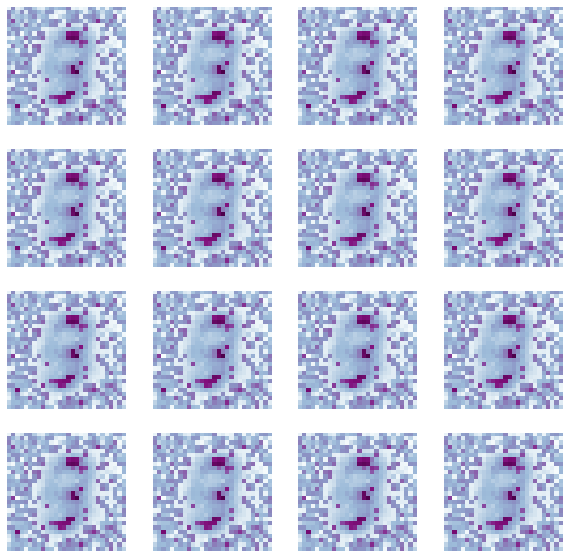

In [43]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_pil_image(0.5*Fakceimage[i]+0.5), cmap = "BuPu")
    plt.axis('off')

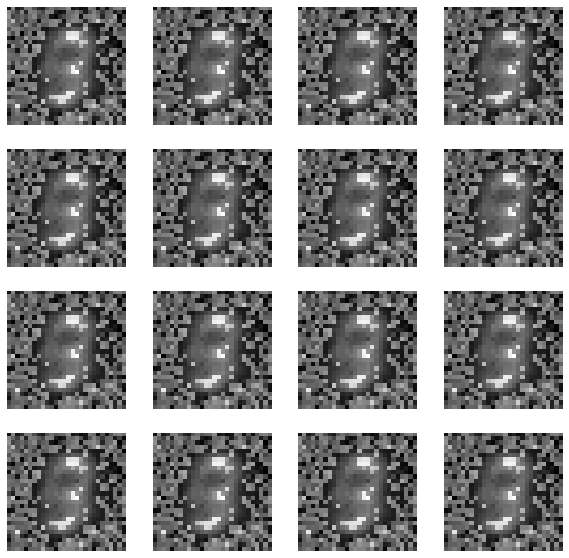

In [44]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_pil_image(0.5*Fakceimage[i]+0.5), cmap = "gray")
    plt.axis('off')

In [47]:
with torch.no_grad():
    fixed_noise = torch.randn(16, 1,28, 28, device = device)
    Fakceimage = model_discriminator(fixed_noise).detach().cpu()

In [55]:
Fakceimage.shape

torch.Size([16, 1, 28, 28])

In [54]:
# plt.figure(figsize=(10, 10))
# for i in range(16):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(to_pil_image(0.5*Fakceimage[i]+0.5), cmap = "gray")
#     plt.axis('off')